In [14]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [15]:
from torch.utils.data import DataLoader

batch_size = 100

loaders = {
    'train' : DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [16]:
import torch.nn as nn

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x
    
model = ConvNN()

In [17]:
from torch.autograd import Variable
from torch import optim
import time

num_epochs = 10

def train(num_epochs, conv_nn, loaders):
    conv_nn.train()

    optimizer = optim.Adam(conv_nn.parameters(), lr = 0.01)   
    loss_func = nn.CrossEntropyLoss()

        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            b_x = Variable(images)   
            b_y = Variable(labels)  
            output = conv_nn(b_x)[0]               
            loss = loss_func(output, b_y)
             
            optimizer.zero_grad()           
            
            loss.backward()              
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
               

train(num_epochs, model, loaders)

file_name = f'convnn-{int(time.time())}.ckpt'

torch.save(model.state_dict(), file_name)

Epoch [1/10], Step [100/600], Loss: 0.1198
Epoch [1/10], Step [200/600], Loss: 0.0966
Epoch [1/10], Step [300/600], Loss: 0.1329
Epoch [1/10], Step [400/600], Loss: 0.0642
Epoch [1/10], Step [500/600], Loss: 0.0233
Epoch [1/10], Step [600/600], Loss: 0.1727
Epoch [2/10], Step [100/600], Loss: 0.1169
Epoch [2/10], Step [200/600], Loss: 0.0521
Epoch [2/10], Step [300/600], Loss: 0.0635
Epoch [2/10], Step [400/600], Loss: 0.0603
Epoch [2/10], Step [500/600], Loss: 0.0268
Epoch [2/10], Step [600/600], Loss: 0.0129
Epoch [3/10], Step [100/600], Loss: 0.0152
Epoch [3/10], Step [200/600], Loss: 0.0263
Epoch [3/10], Step [300/600], Loss: 0.0104
Epoch [3/10], Step [400/600], Loss: 0.0570
Epoch [3/10], Step [500/600], Loss: 0.0988
Epoch [3/10], Step [600/600], Loss: 0.1022
Epoch [4/10], Step [100/600], Loss: 0.0031
Epoch [4/10], Step [200/600], Loss: 0.0249
Epoch [4/10], Step [300/600], Loss: 0.0063
Epoch [4/10], Step [400/600], Loss: 0.0118
Epoch [4/10], Step [500/600], Loss: 0.0052
Epoch [4/10

In [22]:
model = ConvNN()
model.load_state_dict(torch.load("convnn-1687162889.ckpt"))

def test(conv_nn, loaders):
    # Test the model
    conv_nn.eval()
    with torch.no_grad():
        accuracy = []

        for images, labels in loaders['test']:
            test_output, last_layer = conv_nn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy.append((pred_y == labels).sum().item() / float(labels.size(0)))
            
    print(f'Test Accuracy of the model on the 10000 test images: {(sum(accuracy)/len(accuracy)):.2f}')
    
    
test(model, loaders)

Test Accuracy of the model on the 10000 test images: 0.98


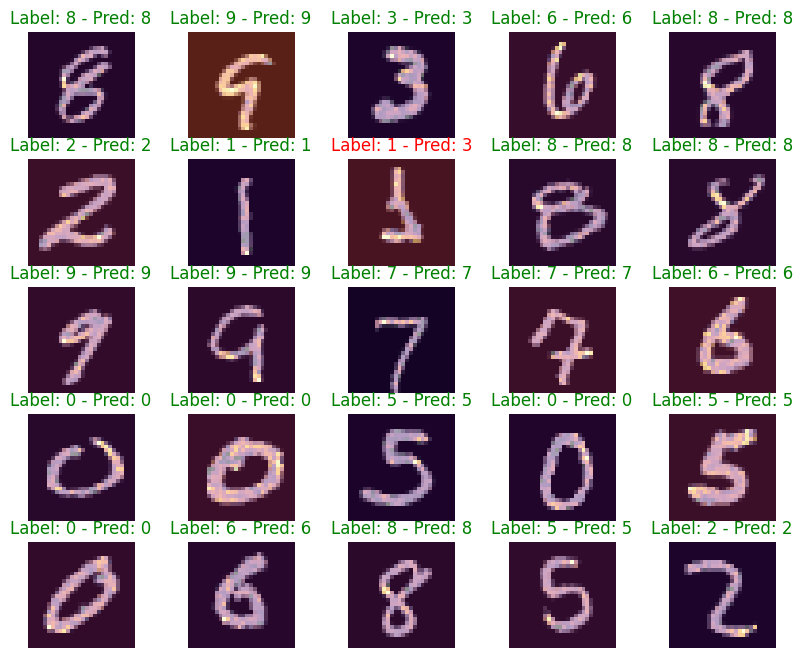

In [35]:
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

figure = plt.figure(figsize=(10, 8))

cols, rows = 5, 5

data = []

def wrapped_model(x):
    output, _ = model(x)
    return output

ig = IntegratedGradients(wrapped_model)

for i in range(cols * rows):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]

    test_output, last_layer = model(img[None, :])
    prediction = torch.max(test_output, 1)[1].data.squeeze()

    attr = ig.attribute(img[None, :], target=label)

    data.append((sample_idx, img, label, prediction, attr))


for i in range(cols * rows):
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"Label: {data[i][2]} - Pred: {data[i][3]}", color=f"{'green' if data[i][2] == data[i][3] else 'red'}")
    plt.axis("off")
    plt.imshow(data[i][1].squeeze(), cmap="gray")
    plt.imshow(data[i][4].squeeze(), cmap=plt.cm.inferno, alpha=0.4)

plt.show()

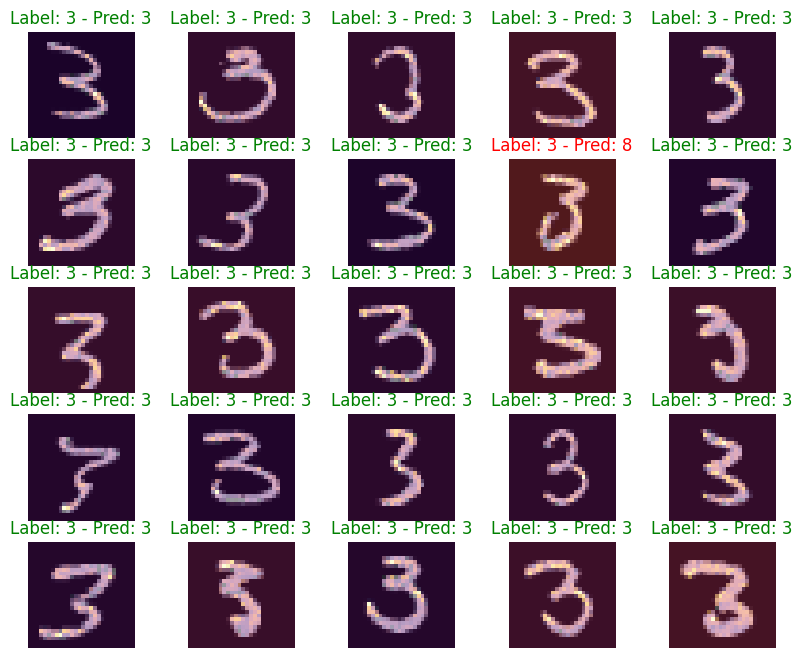

In [40]:
figure = plt.figure(figsize=(10, 8))

cols, rows = 5, 5

data = []

def wrapped_model(x):
    output, _ = model(x)
    return output

ig = IntegratedGradients(wrapped_model)

for i in range(cols * rows):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]

    while label != 3:
        sample_idx = torch.randint(len(test_data), size=(1,)).item()
        img, label = test_data[sample_idx]

    test_output, last_layer = model(img[None, :])
    prediction = torch.max(test_output, 1)[1].data.squeeze()

    attr = ig.attribute(img[None, :], target=label)

    data.append((sample_idx, img, label, prediction, attr))

for i in range(cols * rows):
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"Label: {data[i][2]} - Pred: {data[i][3]}", color=f"{'green' if data[i][2] == data[i][3] else 'red'}")
    plt.axis("off")
    plt.imshow(data[i][1].squeeze(), cmap="gray")
    plt.imshow(data[i][4].squeeze(), cmap=plt.cm.inferno, alpha=0.4)

plt.show()